In [15]:
%pylab inline

from collections import defaultdict
from scipy.spatial.distance import euclidean
from scipy.cluster import vq
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

from soln.dataset import get_augmented_train_and_test_set
from soln.dataset import get_component_info_df
from soln.dataset import load_raw_components

pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [5]:
comp_types, group_dfs, cluster_dfs = load_raw_components()
group_df = group_dfs['elbow']
for feat in ('groove', 'unique_feature', 'orientation'):
    group_df[feat] = (group_df[feat] == 'Yes')
group_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 16 columns):
component_id          178 non-null object
component_type_id     178 non-null object
bolt_pattern_long     171 non-null float64
bolt_pattern_wide     138 non-null float64
extension_length      170 non-null float64
overall_length        175 non-null float64
thickness             171 non-null float64
drop_length           171 non-null float64
elbow_angle           130 non-null float64
mj_class_code         41 non-null object
mj_plug_class_code    40 non-null object
plug_diameter         7 non-null float64
groove                178 non-null bool
unique_feature        178 non-null bool
orientation           178 non-null bool
weight                176 non-null float64
dtypes: bool(3), float64(9), object(4)
memory usage: 20.0+ KB


In [6]:
# Convert mj_class_code to binary features.
group_df.mj_class_code.fillna('MJ-other', inplace=True)
print group_df.mj_class_code.value_counts()
lb = LabelBinarizer()
bin_feats = lb.fit_transform(group_df.mj_class_code.values)
print lb.classes_
tmp_df = pd.DataFrame(bin_feats, columns=lb.classes_)
group_df = group_df.join(tmp_df)
group_df.pop('mj_class_code')
group_df.info()

MJ-other    137
MJ-003       39
MJ-007        1
MJ-004        1
dtype: int64
['MJ-003' 'MJ-004' 'MJ-007' 'MJ-other']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 19 columns):
component_id          178 non-null object
component_type_id     178 non-null object
bolt_pattern_long     171 non-null float64
bolt_pattern_wide     138 non-null float64
extension_length      170 non-null float64
overall_length        175 non-null float64
thickness             171 non-null float64
drop_length           171 non-null float64
elbow_angle           130 non-null float64
mj_plug_class_code    40 non-null object
plug_diameter         7 non-null float64
groove                178 non-null bool
unique_feature        178 non-null bool
orientation           178 non-null bool
weight                176 non-null float64
MJ-003                178 non-null int64
MJ-004                178 non-null int64
MJ-007                178 non-null int64
MJ-other              178

In [8]:
# Convert mj_plug_class_code to binary features.
group_df.mj_plug_class_code.fillna('MJP-other', inplace=True)
print group_df.mj_plug_class_code.value_counts()
lb = LabelBinarizer()
bin_feats = lb.fit_transform(group_df.mj_plug_class_code.values)
print lb.classes_
tmp_df = pd.DataFrame(bin_feats, columns=lb.classes_)
group_df = group_df.join(tmp_df)
group_df.pop('mj_plug_class_code')
group_df.info()

MJP-other    138
MJ-005        23
Threaded       9
MJ-006         8
dtype: int64
['MJ-005' 'MJ-006' 'MJP-other' 'Threaded']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 22 columns):
component_id         178 non-null object
component_type_id    178 non-null object
bolt_pattern_long    171 non-null float64
bolt_pattern_wide    138 non-null float64
extension_length     170 non-null float64
overall_length       175 non-null float64
thickness            171 non-null float64
drop_length          171 non-null float64
elbow_angle          130 non-null float64
plug_diameter        7 non-null float64
groove               178 non-null bool
unique_feature       178 non-null bool
orientation          178 non-null bool
weight               176 non-null float64
MJ-003               178 non-null int64
MJ-004               178 non-null int64
MJ-007               178 non-null int64
MJ-other             178 non-null int64
MJ-005               178 non-null in

In [9]:
# Convert component_type_id to binary features.
print group_df.component_type_id.value_counts()
lb = LabelBinarizer()
bin_feats = lb.fit_transform(group_df.component_type_id.values)
print lb.classes_
tmp_df = pd.DataFrame(bin_feats, columns=lb.classes_)
group_df = group_df.join(tmp_df)
group_df.pop('component_type_id')
group_df.info()

CP-008    70
CP-011    41
CP-010    33
CP-009    27
CP-012     7
dtype: int64
['CP-008' 'CP-009' 'CP-010' 'CP-011' 'CP-012']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 26 columns):
component_id         178 non-null object
bolt_pattern_long    171 non-null float64
bolt_pattern_wide    138 non-null float64
extension_length     170 non-null float64
overall_length       175 non-null float64
thickness            171 non-null float64
drop_length          171 non-null float64
elbow_angle          130 non-null float64
plug_diameter        7 non-null float64
groove               178 non-null bool
unique_feature       178 non-null bool
orientation          178 non-null bool
weight               176 non-null float64
MJ-003               178 non-null int64
MJ-004               178 non-null int64
MJ-007               178 non-null int64
MJ-other             178 non-null int64
MJ-005               178 non-null int64
MJ-006               178 non-null in

In [11]:
# Add features to capture whether a value is missing, and fill missing values with average.
for feat in (
        'bolt_pattern_long', 'bolt_pattern_wide', 'extension_length', 'overall_length',
        'thickness', 'drop_length', 'elbow_angle', 'plug_diameter', 'weight'):
    group_df[feat + '_missing'] = group_df[feat].isnull()
    group_df[feat].fillna(group_df[feat].mean(), inplace=True)
group_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 35 columns):
component_id                 178 non-null object
bolt_pattern_long            178 non-null float64
bolt_pattern_wide            178 non-null float64
extension_length             178 non-null float64
overall_length               178 non-null float64
thickness                    178 non-null float64
drop_length                  178 non-null float64
elbow_angle                  178 non-null float64
plug_diameter                178 non-null float64
groove                       178 non-null bool
unique_feature               178 non-null bool
orientation                  178 non-null bool
weight                       178 non-null float64
MJ-003                       178 non-null int64
MJ-004                       178 non-null int64
MJ-007                       178 non-null int64
MJ-other                     178 non-null int64
MJ-005                       178 non-null int64
MJ-006         

In [12]:
# Get list of vectors to work with.
group_df.set_index('component_id', drop=True, inplace=True)
group_np = group_df.astype(np.float).values
group_np.shape

(178, 34)

In [16]:
# Approach 4: map infrequent components to more frequent substitutes.

freq_cids = ['C-1565', 'C-1208', 'C-1428', 'C-1345', 'C-1317', 'C-0401',
       'C-1587', 'C-1935', 'C-1404', 'C-1349', 'C-1585', 'C-1527',
       'C-1586', 'C-1783', 'C-1598', 'C-0063', 'C-1405', 'C-0598',
       'C-0616', 'C-1432', 'C-1500', 'C-1006']

all_cids = list(group_df.index)

group_np_wh = vq.whiten(group_np)

freq_cid_vecs = []
for cid in freq_cids:
    row_idx = all_cids.index(cid)
    assert row_idx != -1
    row = group_np_wh[row_idx, :]
    freq_cid_vecs.append(row)

cid_to_freq_cid = {}
cid_to_dist = {}
for row_idx, cid in enumerate(group_df.index.values):
    if cid in freq_cids:
        cid_to_freq_cid[cid] = cid
        cid_to_dist[cid] = 0.0
        print "cid {} is frequent enough".format(cid)
    else:
        best_i = None
        best_dist = np.inf
        for i in xrange(len(freq_cids)):
            row = group_np_wh[row_idx, :]
            dist = euclidean(row, freq_cid_vecs[i])
            if dist < best_dist:
                best_dist = dist
                best_i = i
        cid_to_freq_cid[cid] = freq_cids[best_i]
        cid_to_dist[cid] = best_dist
        print "cid {} mapped to freq_cid {} with dist {}".format(cid, freq_cids[best_i], best_dist)

cid C-0013 mapped to freq_cid C-1500 with dist 6.75609910629
cid C-0016 mapped to freq_cid C-1783 with dist 2.07053817998
cid C-0017 mapped to freq_cid C-1783 with dist 0.0931874685552
cid C-0018 mapped to freq_cid C-1783 with dist 1.04356459808
cid C-0021 mapped to freq_cid C-1565 with dist 2.32422795501
cid C-0022 mapped to freq_cid C-0063 with dist 2.05924503405
cid C-0023 mapped to freq_cid C-1349 with dist 5.06544101155
cid C-0028 mapped to freq_cid C-1006 with dist 0.818683276634
cid C-0042 mapped to freq_cid C-1317 with dist 1.18616027948
cid C-0061 mapped to freq_cid C-0063 with dist 1.76151744441
cid C-0063 is frequent enough
cid C-0065 mapped to freq_cid C-1783 with dist 1.24631991514
cid C-0066 mapped to freq_cid C-1783 with dist 1.16068886932
cid C-0075 mapped to freq_cid C-1006 with dist 5.74073844166
cid C-0076 mapped to freq_cid C-1006 with dist 5.57271354837
cid C-0090 mapped to freq_cid C-1598 with dist 5.4514728899
cid C-0094 mapped to freq_cid C-0063 with dist 1.5579

In [17]:
cids = ['C-1992', 'C-0616']
group_df[group_df.index.isin(cids)]

,bolt_pattern_long,bolt_pattern_wide,extension_length,overall_length,thickness,drop_length,elbow_angle,plug_diameter,groove,unique_feature,orientation,weight,MJ-003,MJ-004,MJ-007,MJ-other,MJ-005,MJ-006,MJP-other,Threaded,CP-008,CP-009,CP-010,CP-011,CP-012,bolt_pattern_long_missing,bolt_pattern_wide_missing,extension_length_missing,overall_length_missing,thickness_missing,drop_length_missing,elbow_angle_missing,plug_diameter_missing,weight_missing
component_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C-0616,52.37,26.19,42.10,72.10,38,27,90,50.142857,True,False,True,0.699,0,0,0,1,0,0,1,0,1,0,0,0,0,False,False,False,False,False,False,False,True,False
C-1992,47.63,22.23,46.89,71.89,30,23,90,50.142857,True,False,True,1.100,0,0,0,1,0,0,1,0,1,0,0,0,0,False,False,False,False,False,False,False,True,False


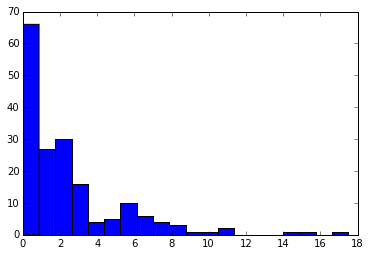

In [18]:
dists = cid_to_dist.values()
hist(dists, bins=20);

In [19]:
df = pd.Series(cid_to_freq_cid, name='cluster')
df.index.name = 'component_id'
df = df.reset_index()
df.to_csv("clu_elbow.csv", index=False)